# Importing libraries and loading sample data

The goal of this script is to just get a feel of training a lightgbm model, saving predictions and submitting to Kaggle. I'm going to train the lightGBM model on the sample data. I want to try different models as well but all of the kaggle kernels used this model and it seemed like a good place to start

In [0]:
#from google.colab import drive
#drive.mount('/gdrive')
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import lightgbm as lgb
import gc
import pickle

In [0]:
#connecting to kaggle and importing datasets
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c talkingdata-adtracking-fraud-detection
!unzip test.csv.zip


In [29]:
!unzip train_sample.csv.zip

dypes = dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

#reading in training data sample
sample = pd.read_csv('mnt/ssd/kaggle-talkingdata2/competition_files/train_sample.csv', dtype=dtypes)
sample['hour'] = pd.to_datetime(sample['click_time']).dt.hour.astype('uint8')
sample['day'] = pd.to_datetime(sample['click_time']).dt.day.astype('uint8')
sample.head(5)
#test=pd.read_csv('test.csv')

Archive:  train_sample.csv.zip
replace mnt/ssd/kaggle-talkingdata2/competition_files/train_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,9,7
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,13,7
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,18,7
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,4,7
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9


# Creating train and validation datasets

In [30]:
#just going to test training model, predicting and submitting using the sample 
#data. I want to get used to the submission process

#shuffling sample and splitting into 80-20 train-val datasets
sample_shuff = sample.sample(frac=1)
r=0.20
len_train=len(sample)
val = sample_shuff[(len_train-round(r*len_train)):len_train]
train = sample_shuff[:(len_train-round(r*len_train))]

display(val.shape)
display(train.shape)

(20000, 10)

(80000, 10)

# Setting model parameters and training

I took parameters that seemed popular on the Kaggle kernels. I want to do hyperparameter tuning eventually.

In [31]:
#training model with popular parameters
target = 'is_attributed'
predictors = ['app','device', 'os', 'ip', 'channel', 'day', 'hour']
categorical = ['app', 'device', 'os', 'ip', 'channel', 'day', 'hour']

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 255,  
    'max_depth': 8,  
    'min_child_samples': 100,  
    'max_bin': 100,  
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.7,  
    'min_child_weight': 0,  
    'subsample_for_bin': 200000,  
    'min_split_gain': 0,  
    'reg_alpha': 0,  
    'reg_lambda': 0,  
   # 'nthread': 8,
    'verbose': 0,
    'scale_pos_weight':99 
    }
    
dtrain = lgb.Dataset(train[predictors].values, label=train[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
dvalid = lgb.Dataset(val[predictors].values, label=val[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

evals_results = {}

lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=350,
                 early_stopping_rounds=30,
                 verbose_eval=True, 
                 feval=None)



/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's auc: 0.916723	valid's auc: 0.891093
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.925996	valid's auc: 0.889552
[3]	train's auc: 0.931477	valid's auc: 0.867626
[4]	train's auc: 0.9336	valid's auc: 0.868179
[5]	train's auc: 0.935326	valid's auc: 0.86806
[6]	train's auc: 0.946611	valid's auc: 0.8809
[7]	train's auc: 0.958612	valid's auc: 0.885697
[8]	train's auc: 0.964907	valid's auc: 0.891785
[9]	train's auc: 0.969979	valid's auc: 0.906067
[10]	train's auc: 0.869685	valid's auc: 0.868419
[11]	train's auc: 0.902502	valid's auc: 0.849201
[12]	train's auc: 0.9745	valid's auc: 0.930048
[13]	train's auc: 0.883151	valid's auc: 0.753904
[14]	train's auc: 0.884253	valid's auc: 0.757287
[15]	train's auc: 0.98037	valid's auc: 0.943144
[16]	train's auc: 0.981221	valid's auc: 0.942561
[17]	train's auc: 0.981858	valid's auc: 0.942265
[18]	train's auc: 0.982483	valid's auc: 0.943124
[19]	train's auc: 0.977761	valid's auc: 0.943792
[20]	train's auc: 0.9816

# Feature importance

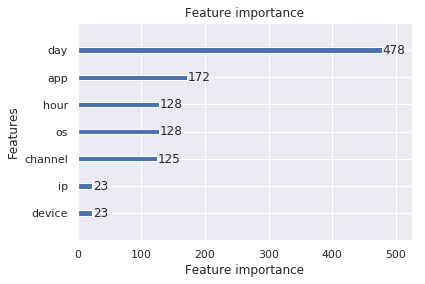

In [32]:
lgb.plot_importance(lgb_model, importance_type='split')

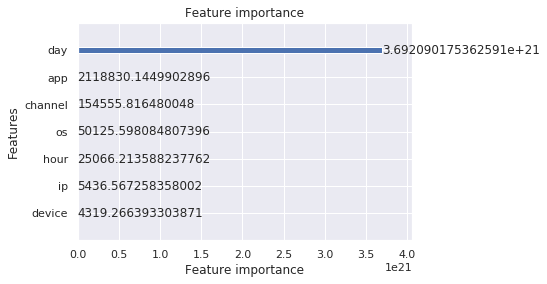

In [40]:
lgb.plot_importance(lgb_model, importance_type='gain')

Day surprisingly ranks the highest for feature importance.  I think this is likely an artifact of how the data was sampled.

# Creating submission file 
Need to include click_id and is_attributed column

In [35]:
#predicting on test data
y_pred=lgb_model.predict(test[['app', 'device', 'os', 'channel']])
test['is_attributed']=0
test.loc[y_pred>0.5, 'is_attributed']=1
test['is_attributed'].value_counts()

0    18303288
1      487181
Name: is_attributed, dtype: int64

In [36]:
#want to see what proportion it predicts as is_attributed
546019/len(test)

0.029058295458192128

In [0]:
#saving submission example to google drive
#from google.colab import drive
#drive.mount('/gdrive')
submission=test[['click_id', 'is_attributed']]
submission.to_csv('/gdrive/My Drive/kaggle/test_sub.csv', index=False)
